In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
os.chdir('..')

In [22]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve

import matplotlib.pyplot as plt

import torch
from torchinfo import summary

import pytorch_lightning as pl

from src.models.autoencoder import FraudDataModule, AutoEncoder

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
BEST_MODEL_PATH = 'logs/ae/checkpoints/autoencoder.ckpt'

In [5]:
dataset = pd.read_csv('data/creditcard.csv')
dm = FraudDataModule(
        dataset, 128, 128, 1, 4, drop_positive=True, target_name='Class', data_test=dataset
    )
dm.setup(stage='test')
dl = dm.test_dataloader()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
model = AutoEncoder.load_from_checkpoint(BEST_MODEL_PATH, map_location=device)

In [12]:
trainer = pl.Trainer(accelerator='cuda' if torch.cuda.is_available() else 'cpu', devices=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\n.Belousov\Anaconda3\envs\daniyal\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [13]:
trainer.predict(model, dl)

Predicting: 0it [00:00, ?it/s]

[tensor(0.0150),
 tensor(0.0067),
 tensor(0.1053),
 tensor(0.0322),
 tensor(0.0607),
 tensor(0.0047),
 tensor(0.0093),
 tensor(0.0935),
 tensor(0.0182),
 tensor(0.0075),
 tensor(0.0179),
 tensor(0.0565),
 tensor(0.0131),
 tensor(0.0057),
 tensor(0.1200),
 tensor(0.0384),
 tensor(0.0093),
 tensor(0.0230),
 tensor(0.3293),
 tensor(0.0106),
 tensor(0.0188),
 tensor(0.0264),
 tensor(0.0323),
 tensor(0.1164),
 tensor(0.1851),
 tensor(0.0323),
 tensor(0.0082),
 tensor(0.0117),
 tensor(0.0072),
 tensor(0.0056),
 tensor(0.0069),
 tensor(0.0067),
 tensor(0.0178),
 tensor(0.0178),
 tensor(0.0253),
 tensor(0.0253),
 tensor(0.0107),
 tensor(0.0329),
 tensor(0.0120),
 tensor(0.0068),
 tensor(0.0201),
 tensor(0.0493),
 tensor(0.0121),
 tensor(0.0521),
 tensor(0.0357),
 tensor(0.0035),
 tensor(0.0984),
 tensor(0.1529),
 tensor(0.0445),
 tensor(0.0314),
 tensor(0.0568),
 tensor(0.4597),
 tensor(0.0602),
 tensor(0.0142),
 tensor(0.0127),
 tensor(0.0586),
 tensor(0.0780),
 tensor(0.0434),
 tensor(0.0033

In [24]:
summary(model, input_size=(1, 29))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 29]                   --
├─Sequential: 1-1                        [1, 16]                   --
│    └─Linear: 2-1                       [1, 512]                  15,360
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─Dropout: 2-7                      [1, 256]                  --
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─BatchNorm1d: 2-10                 [1, 128]                  256
│    └─Dropout: 2-11                     [1, 128]                  

In [14]:
losses = np.array(model.pred_losses)

In [15]:
losses = pd.DataFrame(losses, columns=['target', 'loss'])

In [16]:
losses

,target,loss
0,0.0,0.015026
1,0.0,0.006715
2,0.0,0.105320
3,0.0,0.032243
4,0.0,0.060671
...,...,...
284802,0.0,0.207670
284803,0.0,0.061063
284804,0.0,0.013661
284805,0.0,0.069820


In [17]:
losses[losses['target'] == 1]['loss'].describe()

count    492.000000
mean       8.366231
std       13.957791
min        0.007194
25%        0.788513
50%        2.406568
75%        8.042916
max       69.997002
Name: loss, dtype: float64

In [18]:
def get_optimum_threshold(y_true, y_pred_proba):
    precisions, recalls, trs = precision_recall_curve(
        y_true, y_pred_proba
    )
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    print(f1_scores.max())
    plt.plot(precisions, recalls)
    plt.show()

    return trs[np.argmax(f1_scores)]

In [19]:
y_true = losses['target'].values.astype(np.int32)

0.49951219462275126


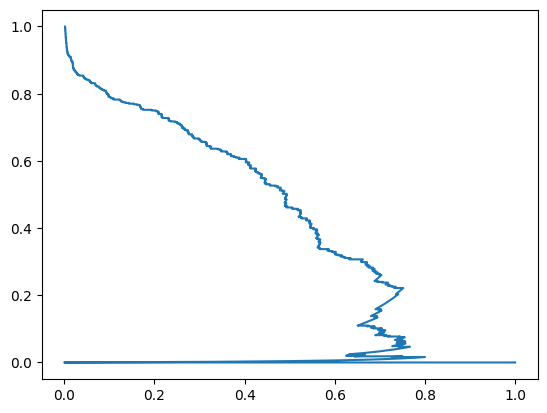

In [20]:
tr = get_optimum_threshold(y_true, losses['loss'])

In [21]:
roc_auc_score(y_true, losses['loss'])

0.953758498710851

In [40]:
pd.read_csv('logs/ae/autoencoder_train_loss.csv')

,Wall time,Step,Value
0,1.685913e+09,39,0.723951
1,1.685913e+09,79,0.661184
2,1.685913e+09,119,0.528170
3,1.685913e+09,139,0.429428
4,1.685913e+09,179,0.411465
...,...,...,...
995,1.685914e+09,28319,0.148800
996,1.685914e+09,28339,0.135051
997,1.685914e+09,28359,0.160091
998,1.685914e+09,28399,0.134531


In [46]:
def my_tb_smooth(scalars: list[float], weight: float) -> list[float]:

    last = scalars[0]
    smoothed: list = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

In [54]:
train_loss = pd.read_csv('logs/ae/autoencoder_train_loss.csv')[['Step', 'Value']].values
val_loss = pd.read_csv('logs/ae/autoencoder_val_loss.csv')[['Step', 'Value']].values

In [55]:
train_loss[:, 1] = my_tb_smooth(train_loss[:, 1], .9)

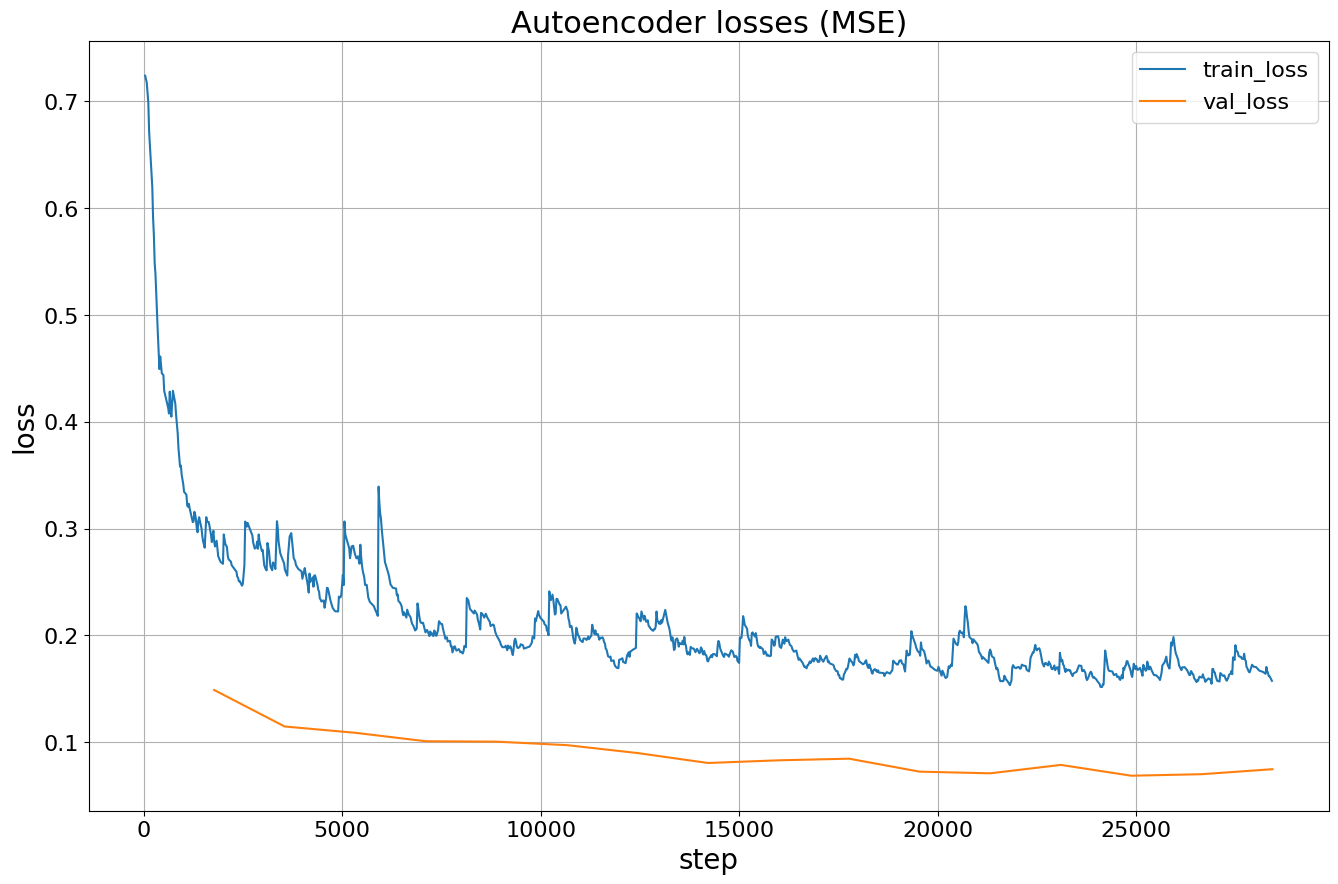

In [71]:
plt.figure(figsize=(16, 10))

plt.plot(train_loss[:, 0], train_loss[:, 1], label='train_loss')
plt.plot(val_loss[:, 0], val_loss[:, 1], label='val_loss')

plt.title('Autoencoder losses (MSE)', size=22)
plt.xlabel('step', size=20)
plt.xticks(size=16)
plt.ylabel('loss', size=20)
plt.yticks(size=16)

plt.grid(True)
plt.legend(prop={'size':16})
plt.show();